In [ ]:
!pip install pyarrow==0.15

In [ ]:
import pandas as pd
import pyarrow
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Preprocessing

In [ ]:
clients = pd.read_csv("/content/drive/My Drive/lenta_hack/clients.csv")
clients.head(5)

,client_id,gender,city,birthyear
0,1a47d62dddacc03fe90c15652f7ae1a4,M,Other,1990.0
1,9cb909f701d25d548e953bff81192b56,F,Other,1969.0
2,d5da0f5b841b4f83383202807995027a,M,Other,1976.0
3,13ed7f16810b17b8cee6de834ac79a48,F,Moscow,1966.0
4,215fe3ea7d5bf0415e5504e2a7f33551,F,Other,1988.0


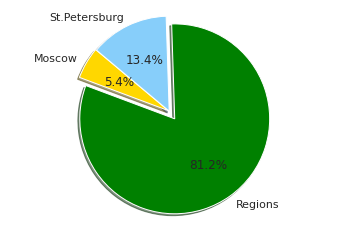

In [ ]:
# Data to plot
labels = 'Moscow', 'Regions', 'St.Petersburg'
sizes = list(clients.groupby(['city']).count()['client_id'])
colors = ['gold', 'green', 'lightskyblue']
explode = (0.01, 0.1, 0)  

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.savefig('cities.png', transparent=True)
plt.show()

In [ ]:
transactions = pd.read_parquet("/content/drive/My Drive/lenta_hack/transactions.parquet", engine='pyarrow', columns=['chq_id', 'client_id', 'sales_sum'])
transactions.head()

,chq_id,client_id,sales_sum
0,ce5b3d1c531348c5d0d8e859b6d0cf91,90fca68123e692a005a4edeadd94b2f2,146.98
1,ce5b3d1c531348c5d0d8e859b6d0cf91,90fca68123e692a005a4edeadd94b2f2,249.99
2,ce5b3d1c531348c5d0d8e859b6d0cf91,90fca68123e692a005a4edeadd94b2f2,47.99
3,ce5b3d1c531348c5d0d8e859b6d0cf91,90fca68123e692a005a4edeadd94b2f2,47.99
4,ce5b3d1c531348c5d0d8e859b6d0cf91,90fca68123e692a005a4edeadd94b2f2,53.98


In [ ]:
# returns of transactions
transactions[transactions['sales_sum']<0]

,chq_id,client_id,sales_sum
381,ec4574e5bf5e450785a34ceac2d4fa0d,548b17a993269db30cf7e02d50a672c4,-894.06
382,ec4574e5bf5e450785a34ceac2d4fa0d,548b17a993269db30cf7e02d50a672c4,-525.79
488,c2488b6b263a02b1b9b23139f3ff9e49,1084cd03ddbc36db147d51fdbe653c38,-74.16
1990,c1b703a0ac6b6f1a4a220b8b6b82c1ac,0efd1fe9f7ba6ba603d25b6f4253d4f4,-348.43
3000,28c011c824e95bc651c5cb1c3eea00b3,897fa9fcd8f657fb38e8f9f8431a7e4b,-299.85
...,...,...,...
32095041,41a2574aeca77c829bdab47eb041f0f1,b1d3c45219a3f8e6df370559446e2228,-46.89
32095043,41a2574aeca77c829bdab47eb041f0f1,b1d3c45219a3f8e6df370559446e2228,-67.99
32101658,cfc50c24be35a27e8267486166e2a5e2,c2e40883f25d08c0152454c0bd8f5d1a,-431.06
32106141,584f7148b5009f2ef0e34cf6f98d8f6d,a0df75ec20ce65c6a320883a7e79b1a3,-4998.26


In [ ]:
# drop all returned goods
transactions = transactions[transactions.select_dtypes(include=[np.number]).ge(0).all(1)]
transactions = transactions.dropna()
transactions.shape

(32086641, 3)

In [ ]:
materials = pd.read_csv("/content/drive/My Drive/lenta_hack/materials.csv")
materials.tail(5)

,material,hier_level_1,hier_level_2,hier_level_3,hier_level_4,vendor,is_private_label,is_alco
105604,feeddbacd9eed3bac85b1571ac79e40e,NONFOOD,3295c76acbf4caaed33c36b1b5fc2cb1,11704817e347269b7254e744b5e22dac,e47e165040e2914783a451509bbc8180,8ca0d8745f91fb71551be26b1ca854f4,0,0
105605,e218c4c3676927e53b95a12ffe9e721a,FOOD,02e74f10e0327ad868d138f2b4fdd6f0,df0e09d6f25a15a815563df9827f48fa,a03ddfb4b641e98de3223765162217c3,e3319f2f4767af113d82174f662f2d4e,1,1
105606,9a5e2e34d8406616f5981868b4576444,NONFOOD,fc490ca45c00b1249bbe3554a4fdf6fb,865bf46435bd84fa5d89f64cf3ba7347,e2a75db437bee7d34615fccf32d7a464,546614030cdbddcae3de351852962759,0,0
105607,d208910eb82fa1f57684f793f93521a4,NONFOOD,ea5d2f1c4608232e07d3aa3d998e5135,90365351ccc7437a1309dc64e4db32a3,ea9cffc9bd2bf8a0fb128d223f6a4282,7f1dbcf6ab15c23093508627ca12b8b1,0,0
105608,ac6bf06bbda21e48809e734c1f6fa010,NONFOOD,ea5d2f1c4608232e07d3aa3d998e5135,90365351ccc7437a1309dc64e4db32a3,65415da77b0f2c4d59897a3c1d7130f5,7f1dbcf6ab15c23093508627ca12b8b1,0,0


In [ ]:
plants = pd.read_csv("/content/drive/My Drive/lenta_hack/plants.csv")
plants.tail(4)

,plant,plant_type,city
384,238d77348d954fdd455aabb09575f2d0,SM,Other
385,6e1acaeb838a890e6570284f73e1d00f,SM,Other
386,7fc3ee9aad33036cc501b2ca7c163fc1,SM,Other
387,8a5dd78aadea6ffc984bda22064adb92,SM,Other


In [ ]:
plants["city"].unique()

array(['St. Petersburg', 'Other', 'Moscow'], dtype=object)

In [ ]:
# calculate sums for each client for each check
grouped_for_sums = transactions[['chq_id', 'client_id', 'sales_sum']].groupby(by=['chq_id', 'client_id'], as_index=False).sum()
grouped_for_sums.head(3)
# grouped_for_count = transactions[['chq_id', 'chq_date', 'client_id', 'material']].groupby(by=['chq_id', 'chq_date', 'client_id'], 
#                                                                                          as_index=False).count()

,chq_id,client_id,sales_sum
0,00000391443926003b45cebac9a4c0b2,8a5c839e26cb4a6eedadce113cceb253,164.0
1,0000086694a97b18d2b5e5cfc309ab76,191412d730a981ce6ae809b8ef8a1070,821.0
2,00000b7bb8fd947f62aeed1bba4b6fbb,19c47bc27fdb0c828ef60074a67b8733,326.0


In [ ]:
# merge clients demographical info and transactions
grouped_for_sums = grouped_for_sums.merge(clients, how='left', left_on='client_id', right_on='client_id')
grouped_for_sums = grouped_for_sums.dropna()
grouped_for_sums.head(3)

,chq_id,client_id,sales_sum,gender,city,birthyear
0,00000391443926003b45cebac9a4c0b2,8a5c839e26cb4a6eedadce113cceb253,164.0,M,Other,1989.0
1,0000086694a97b18d2b5e5cfc309ab76,191412d730a981ce6ae809b8ef8a1070,821.0,F,Moscow,1987.0
2,00000b7bb8fd947f62aeed1bba4b6fbb,19c47bc27fdb0c828ef60074a67b8733,326.0,F,Other,1969.0


In [ ]:
# split by region
grouped_for_sums['years'] = (2020 - grouped_for_sums['birthyear']) // 20
grouped_for_sums = grouped_for_sums[grouped_for_sums.select_dtypes(include=[np.number]).ge(0).all(1)]
grouped_for_sums = grouped_for_sums[grouped_for_sums['years'] < 4]
grouped_for_sums = grouped_for_sums[grouped_for_sums['years'] >= 0]

grouped_for_sums_region = grouped_for_sums[grouped_for_sums['city'] == 'Other'][['sales_sum', 'gender', 'years']]
grouped_for_sums_moscow_pet = grouped_for_sums[grouped_for_sums['city'] != 'Other'][['sales_sum', 'gender', 'years']]

In [ ]:
grouped_for_sums_region.head()

,sales_sum,gender,years
0,164.0,M,1.0
2,326.0,F,2.0
3,1713.0,M,2.0
4,2032.0,M,1.0
5,1141.0,M,3.0


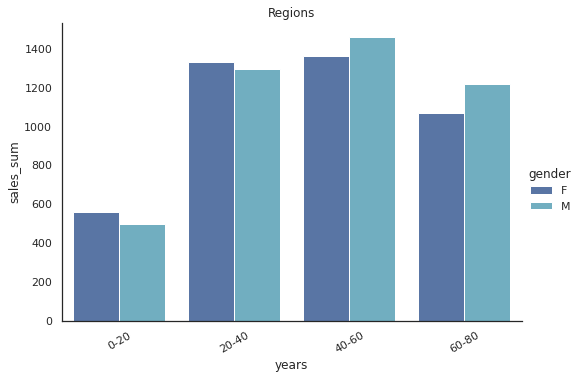

In [ ]:
grouped_for_sums_region = grouped_for_sums_region.groupby(by=['gender', 'years'], as_index=False).mean()

sns.set(style="white")
g = sns.catplot(x='years'
                   ,y= 'sales_sum'
                   ,hue='gender'
                   ,data=grouped_for_sums_region
                   ,kind='bar'
                   ,aspect=1.5
                   ,palette=['b', 'c']
                   ,
                   )
g.set_xticklabels(['0-20', '20-40', '40-60', '60-80', '80-100'], rotation=30)
plt.title('Regions')
plt.savefig('Regions_check_sum.png', transparent=True)
plt.show()

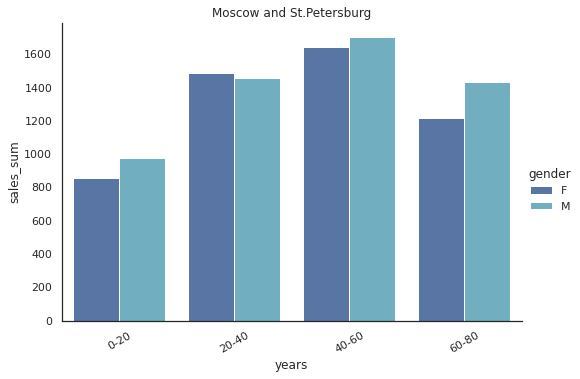

In [ ]:
grouped_for_sums_moscow_pet = grouped_for_sums_moscow_pet.groupby(by=['gender', 'years'], as_index=False).mean()

sns.set(style="white")
g = sns.catplot(x='years'
                   ,y= 'sales_sum'
                   ,hue='gender'
                   ,data=grouped_for_sums_moscow_pet
                   ,kind='bar'
                   ,aspect=1.5
                   ,palette=['b', 'c']
                   )
g.set_xticklabels(['0-20', '20-40', '40-60', '60-80', '80-100'], rotation=30)
plt.title('Moscow and St.Petersburg')
plt.savefig('Moscow_check_sum.png', transparent=True)
plt.show()

## Check time series of purchases of one type 

In [ ]:
transactions = pd.read_parquet("/content/drive/My Drive/lenta_hack/transactions.parquet", engine='pyarrow', columns=['chq_date', 'material'])

In [ ]:
transactions.head()

,chq_date,material
0,2016-11-01,232cfe8b28970434f685b737737b26d4
1,2016-11-01,12ec64451b8e426db16f3f05ea770901
2,2016-11-01,1212ff8ecf53aebef093ca8ae216db68
3,2016-11-01,1212ff8ecf53aebef093ca8ae216db68
4,2016-11-01,571c6d3b559db8445e05265649eb30ab


In [ ]:
materials_two_columns = materials[['material', 'hier_level_4']]
materials_two_columns.head()

,material,hier_level_4
0,35cbdf61de9e19c8b417327aaef14c88,9eed45f71360b4b1e2590637467220e5
1,c0b0bf24d4ec71da3d304f761ec555d8,de2eb747e0896c050905a6b635ab800a
2,f0fc5e654a81a7c4b8ba8d7c26546e14,8a969031832c535daf96e0c2aed8e814
3,353693e64fb5f9e2d29746d7fe6edf1e,4c0dc012ebb679a18b244c53c6f59b5a
4,5d9e0b4302ce95448cae72165ff4cf5b,4c0dc012ebb679a18b244c53c6f59b5a


In [ ]:
df_categ_date = transactions.merge(materials_two_columns, how='left', left_on='material', right_on='material').groupby(['chq_date', 'hier_level_4'], as_index=False).count()

In [ ]:
df_categ_date['diff'] = df_categ_date['chq_date'] -   df_categ_date['chq_date'][0]
df_categ_date['sec'] = df_categ_date['diff'].dt.total_seconds()
df_categ_date.tail()

,chq_date,hier_level_4,material,diff,sec
559003,2017-10-04,ff74d586765a550ffc8aae32b30b232c,2,365 days,31536000.0
559004,2017-10-04,ffa0829899912d2575fe413fdb53086d,124,365 days,31536000.0
559005,2017-10-04,ffa247ae4a097dc6a7e45ed492a5f069,17,365 days,31536000.0
559006,2017-10-04,ffa5a75bfd08cbe4a6a3b3328d5876ac,99,365 days,31536000.0
559007,2017-10-04,fff7988c2a0b3a775308c2c12e556e73,7,365 days,31536000.0


In [ ]:
df_categ_date.shape

(559008, 5)

In [ ]:
df_categ_date_elem = df_categ_date[df_categ_date['hier_level_4'] == 'ffa5a75bfd08cbe4a6a3b3328d5876ac']
df_categ_date_elem.head()

,chq_date,hier_level_4,material,diff,sec
1510,2016-10-04,ffa5a75bfd08cbe4a6a3b3328d5876ac,134,0 days,0.0
3072,2016-10-05,ffa5a75bfd08cbe4a6a3b3328d5876ac,111,1 days,86400.0
4618,2016-10-06,ffa5a75bfd08cbe4a6a3b3328d5876ac,96,2 days,172800.0
6187,2016-10-07,ffa5a75bfd08cbe4a6a3b3328d5876ac,94,3 days,259200.0
7794,2016-10-08,ffa5a75bfd08cbe4a6a3b3328d5876ac,169,4 days,345600.0


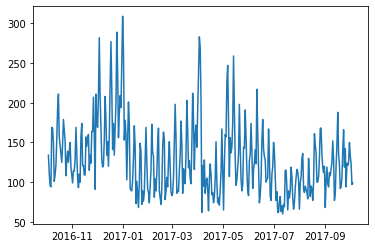

In [ ]:
plt.plot(df_categ_date_elem['chq_date'], df_categ_date_elem['material'])
plt.show()